In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import itertools
import numpy as np
import random
from fbprophet import Prophet
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

F:\anaconda_install\envs\timeseries\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# 读取数据和简单数据分析

In [2]:
df = pd.read_excel("./data/Groceries_Sales_data.xlsx")

In [3]:
print('-'*60)
print('*** Head of the dataframe ***')
print('-'*60)
print(df.head())
print('-'*60)
print('*** Tail of the dataframe ***')
print('-'*60)
print(df.tail())

------------------------------------------------------------
*** Head of the dataframe ***
------------------------------------------------------------
        Date    Sales
0 2018-02-01  21199.0
1 2018-02-02  10634.0
2 2018-02-03   7966.0
3 2018-02-04   1353.0
4 2018-02-05   9497.0
------------------------------------------------------------
*** Tail of the dataframe ***
------------------------------------------------------------
          Date    Sales
751 2020-02-22  18723.1
752 2020-02-23   4274.9
753 2020-02-24  45805.7
754 2020-02-25  35566.3
755 2020-02-26  46703.0


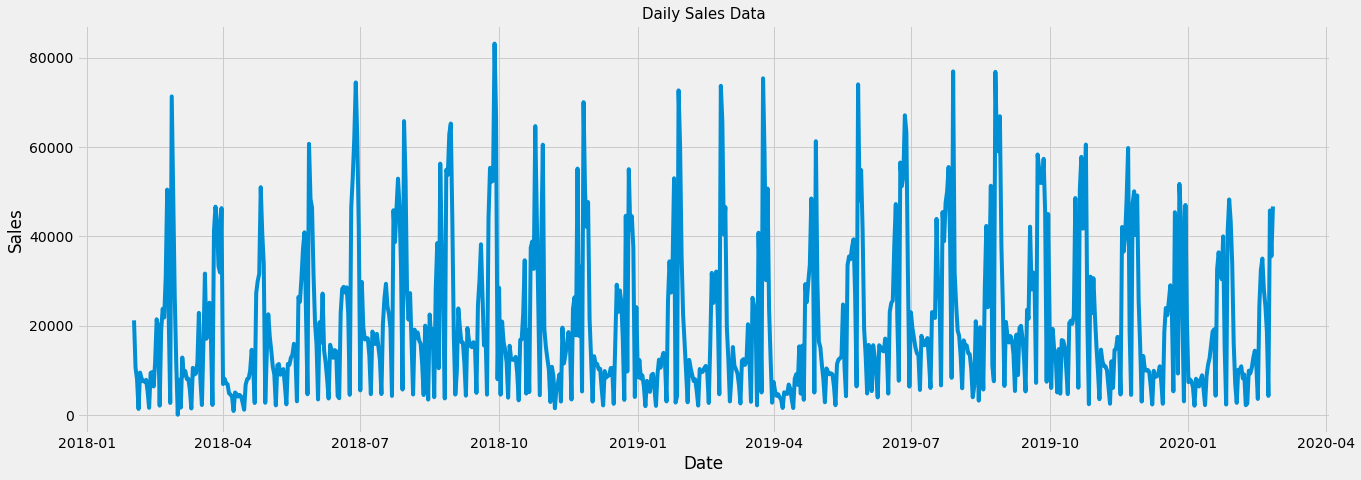

In [4]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(20,7))
a = sns.lineplot(x="Date", y="Sales", data=df)
a.set_title("Daily Sales Data",fontsize=15)
plt.show()

In [5]:
## 时间相关的特征
def date_features(df, label=None):
    df = df.copy()
    
    df['date'] = df.Date
    df['month'] = df['date'].dt.strftime('%B')
    df['year'] = df['date'].dt.strftime('%Y')
    df['dayofweek'] = df['date'].dt.strftime('%A')
    df['quarter'] = df['date'].dt.quarter
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X
X, y = date_features(df, label='Sales')
df_new = pd.concat([X, y], axis=1)
df_new.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Sales
0,Thursday,1,February,2018,32,1,5,21199.0
1,Friday,1,February,2018,33,2,5,10634.0
2,Saturday,1,February,2018,34,3,5,7966.0
3,Sunday,1,February,2018,35,4,5,1353.0
4,Monday,1,February,2018,36,5,6,9497.0


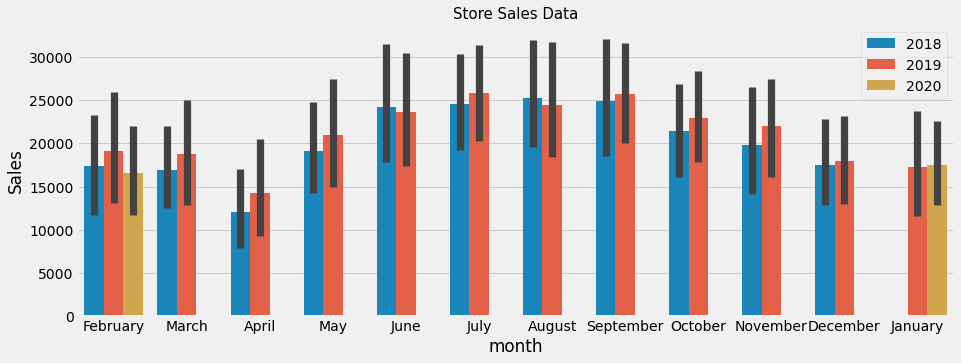

In [6]:
fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="month", y="Sales",hue = 'year',data=df_new)
a.set_title("Store Sales Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

Text(0.5, 1.0, 'Total Sales received By year')

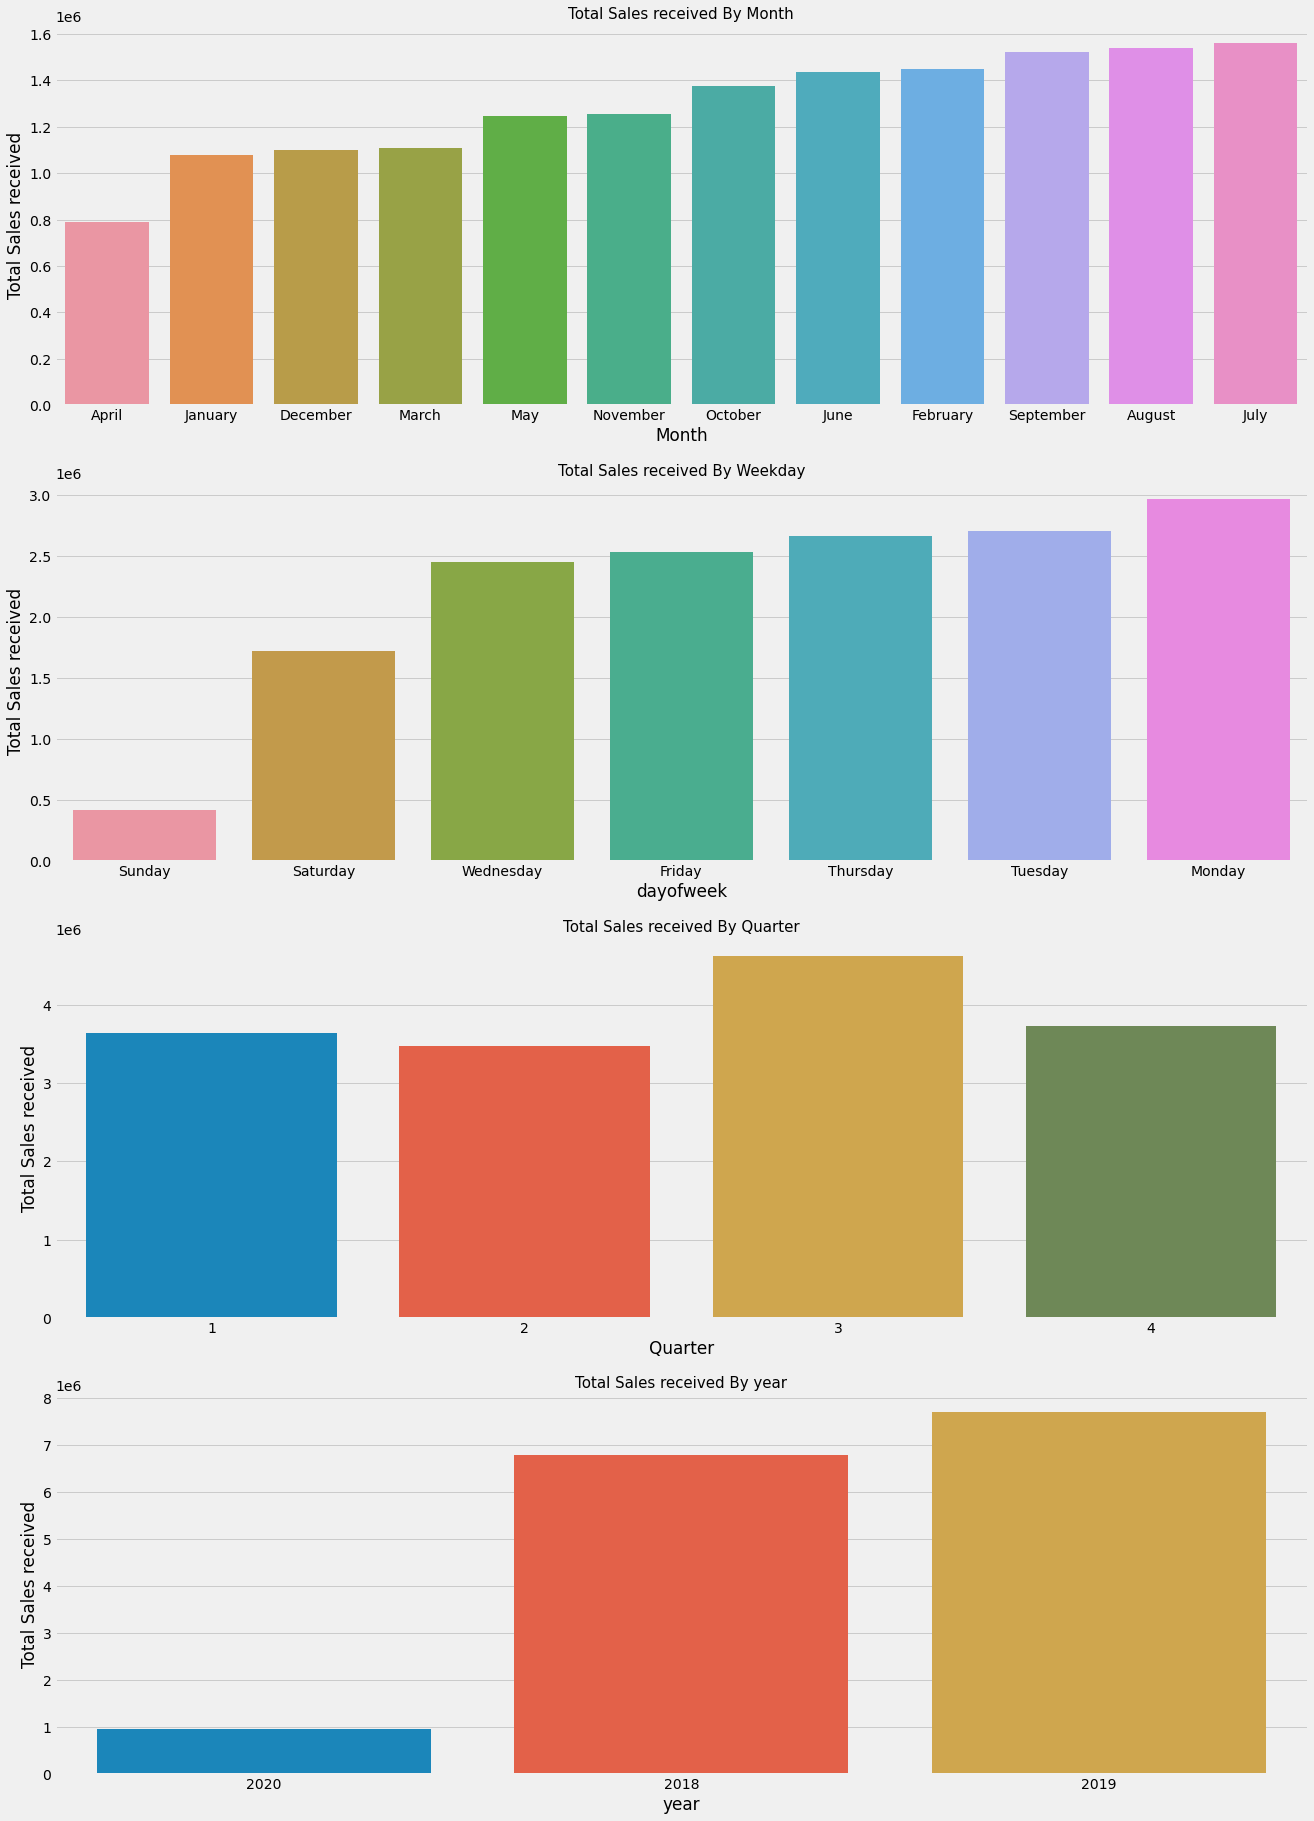

In [7]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(20,30)

monthAggregated = pd.DataFrame(df_new.groupby("month")["Sales"].sum()).reset_index().sort_values('Sales')
sns.barplot(data=monthAggregated,x="month",y="Sales",ax=ax1)
ax1.set(xlabel='Month', ylabel='Total Sales received')
ax1.set_title("Total Sales received By Month",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("dayofweek")["Sales"].sum()).reset_index().sort_values('Sales')
sns.barplot(data=monthAggregated,x="dayofweek",y="Sales",ax=ax2)
ax2.set(xlabel='dayofweek', ylabel='Total Sales received')
ax2.set_title("Total Sales received By Weekday",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("quarter")["Sales"].sum()).reset_index().sort_values('Sales')
sns.barplot(data=monthAggregated,x="quarter",y="Sales",ax=ax3)
ax3.set(xlabel='Quarter', ylabel='Total Sales received')
ax3.set_title("Total Sales received By Quarter",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("year")["Sales"].sum()).reset_index().sort_values('Sales')
sns.barplot(data=monthAggregated,x="year",y="Sales",ax=ax4)
ax4.set(xlabel='year', ylabel='Total Sales received')
ax4.set_title("Total Sales received By year",fontsize=15)

In [8]:
df=df.rename(columns={'Date':'ds','Sales':'y'})
df.head()

,ds,y
0,2018-02-01,21199.0
1,2018-02-02,10634.0
2,2018-02-03,7966.0
3,2018-02-04,1353.0
4,2018-02-05,9497.0


In [9]:
end_date = '2019-12-31'
mask1 = (df['ds'] <= end_date)
mask2 = (df['ds'] > end_date)

In [10]:
X_tr = df.loc[mask1]
X_tst = df.loc[mask2]
print("train shape",X_tr.shape)
print("test shape",X_tst.shape)

train shape (699, 2)
test shape (57, 2)


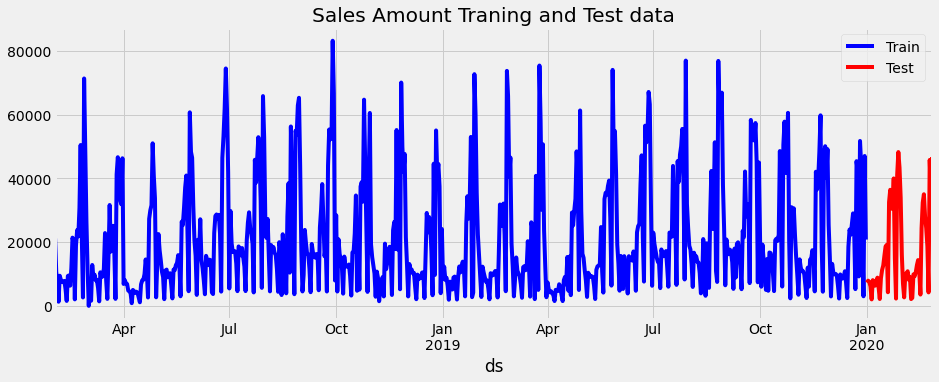

In [11]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
X_tr.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
X_tst.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
plt.title('Sales Amount Traning and Test data')
plt.show()

In [12]:
## 定义metric MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 训练prophet模型

In [13]:
model = Prophet()
model.fit(X_tr)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
future = model.make_future_dataframe(periods=57, freq='D')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
749,2020-02-20,28024.353283,8643.217369,46392.535191
750,2020-02-21,26716.177469,6873.593725,45723.959370
751,2020-02-22,19187.217659,-780.378700,39260.580529
752,2020-02-23,6786.778511,-12141.241015,25316.088627
753,2020-02-24,30639.534287,12079.039337,50158.750482
754,2020-02-25,27903.336091,8230.027302,46697.299406
755,2020-02-26,25505.529638,6540.609591,44607.394517


In [15]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-02-01,18405.696899,2954.564465,40913.195923,18405.696899,18405.696899,4507.263647,4507.263647,4507.263647,4507.263647,4507.263647,4507.263647,0.0,0.0,0.0,22912.960545
1,2018-02-02,18412.523015,1559.411814,40343.155769,18412.523015,18412.523015,3192.264048,3192.264048,3192.264048,3192.264048,3192.264048,3192.264048,0.0,0.0,0.0,21604.787063
2,2018-02-03,18419.349132,-5465.059062,33619.084936,18419.349132,18419.349132,-4343.519547,-4343.519547,-4343.519547,-4343.519547,-4343.519547,-4343.519547,0.0,0.0,0.0,14075.829585
3,2018-02-04,18426.175249,-17394.325248,20676.768247,18426.175249,18426.175249,-16750.782480,-16750.782480,-16750.782480,-16750.782480,-16750.782480,-16750.782480,0.0,0.0,0.0,1675.392769
4,2018-02-05,18433.001365,4787.804991,46659.896962,18433.001365,18433.001365,7095.149511,7095.149511,7095.149511,7095.149511,7095.149511,7095.149511,0.0,0.0,0.0,25528.150876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,2020-02-22,23530.737206,-780.378700,39260.580529,23530.732188,23530.742782,-4343.519547,-4343.519547,-4343.519547,-4343.519547,-4343.519547,-4343.519547,0.0,0.0,0.0,19187.217659
752,2020-02-23,23537.560991,-12141.241015,25316.088627,23537.555748,23537.566731,-16750.782480,-16750.782480,-16750.782480,-16750.782480,-16750.782480,-16750.782480,0.0,0.0,0.0,6786.778511
753,2020-02-24,23544.384776,12079.039337,50158.750482,23544.379350,23544.390677,7095.149511,7095.149511,7095.149511,7095.149511,7095.149511,7095.149511,0.0,0.0,0.0,30639.534287
754,2020-02-25,23551.208561,8230.027302,46697.299406,23551.203042,23551.214695,4352.127530,4352.127530,4352.127530,4352.127530,4352.127530,4352.127530,0.0,0.0,0.0,27903.336091


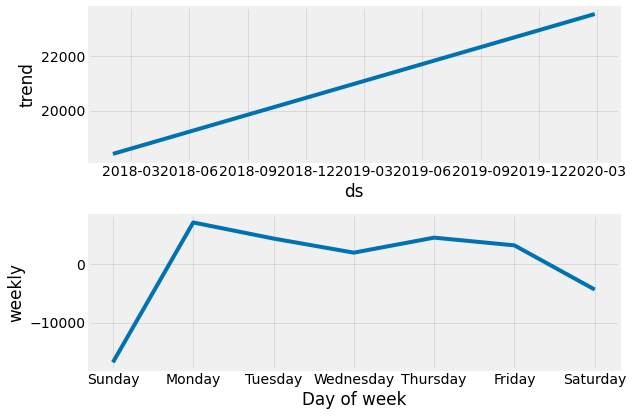

In [15]:
fig = model.plot_components(forecast)

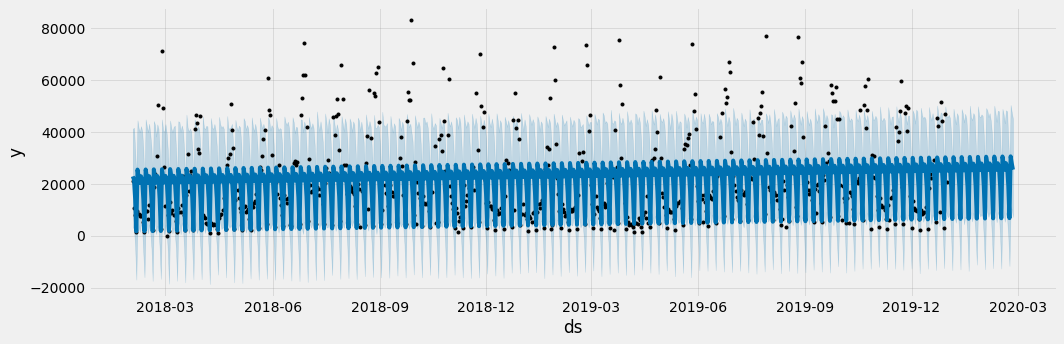

In [16]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast,ax=ax)
plt.show()

In [17]:
X_tst_forecast = model.predict(X_tst)
X_tst_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
50,2020-02-20,28024.353283,8289.266792,47990.820293
51,2020-02-21,26716.177469,6279.578092,46267.879412
52,2020-02-22,19187.217659,-25.188161,38783.581810
53,2020-02-23,6786.778511,-13104.025685,26097.660026
54,2020-02-24,30639.534287,11783.200065,51232.244287
55,2020-02-25,27903.336091,9019.268647,45739.846960
56,2020-02-26,25505.529638,5262.977261,45888.706912


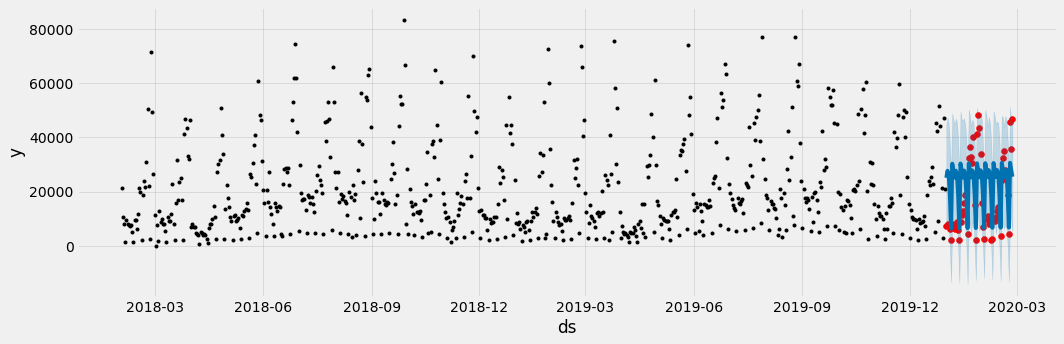

In [18]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(X_tst.ds, X_tst['y'], color='r')
fig = model.plot(X_tst_forecast, ax=ax)

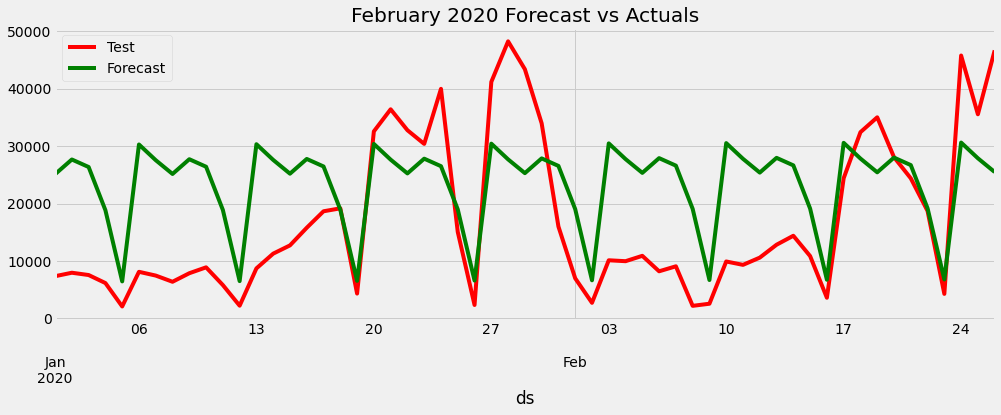

In [19]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
X_tst_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('February 2020 Forecast vs Actuals')
plt.show()

In [22]:
mape = mean_absolute_percentage_error(X_tst['y'],X_tst_forecast['yhat'])
print("MAPE",round(mape,4))

MAPE 129.1593


# 加入节假日信息

In [23]:
import holidays

In [24]:
holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2018,2019,2020]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [25]:
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(X_tr)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [26]:
future = model_with_holidays.make_future_dataframe(periods=57, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
749,2020-02-20,28244.353441,10365.674300,48477.121558
750,2020-02-21,26893.901457,8433.120538,46392.864420
751,2020-02-22,19356.338144,1250.409721,39203.591607
752,2020-02-23,6955.418616,-11731.790527,25854.271067
753,2020-02-24,30969.588026,11969.064883,48414.470368
754,2020-02-25,28108.388219,8725.821792,47797.802256
755,2020-02-26,25710.942000,6092.103282,46239.626456


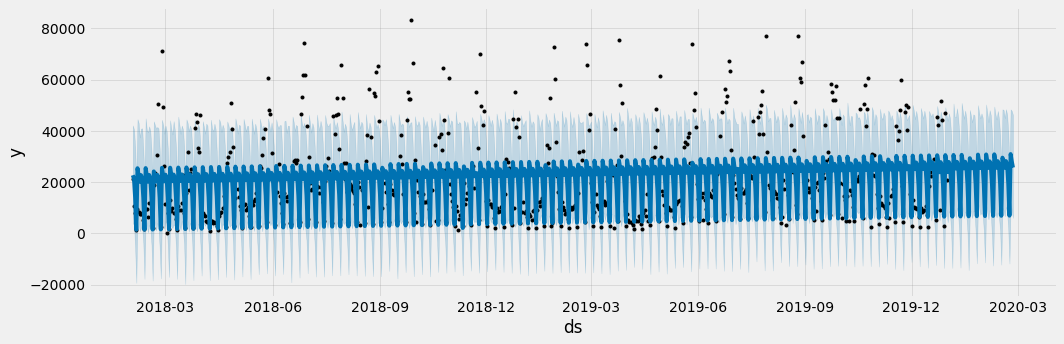

In [27]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

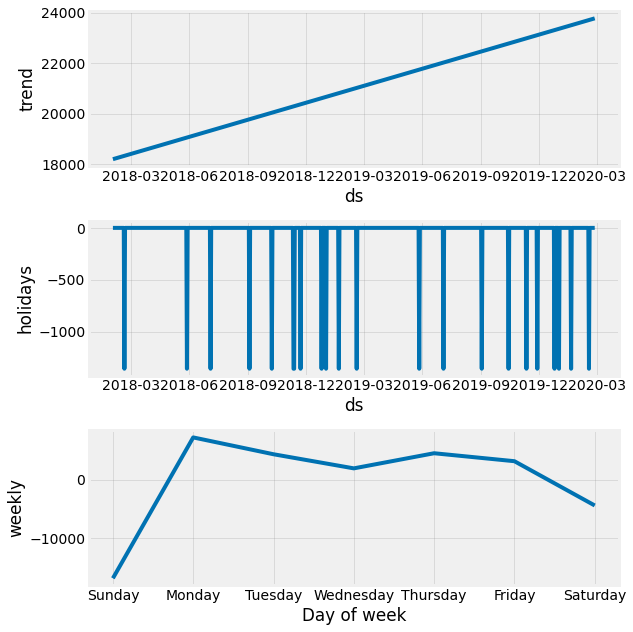

In [28]:
fig = model_with_holidays.plot_components(forecast)


In [29]:
X_tst_forecast_holiday = model_with_holidays.predict(X_tst)
X_tst_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
50,2020-02-20,28244.353441,8060.758089,48290.815416
51,2020-02-21,26893.901457,7460.829004,46016.079794
52,2020-02-22,19356.338144,1548.024621,37777.818131
53,2020-02-23,6955.418616,-11133.322959,27439.103888
54,2020-02-24,30969.588026,12132.316415,50379.389848
55,2020-02-25,28108.388219,8209.209214,48083.895437
56,2020-02-26,25710.942000,6727.708851,44689.438393


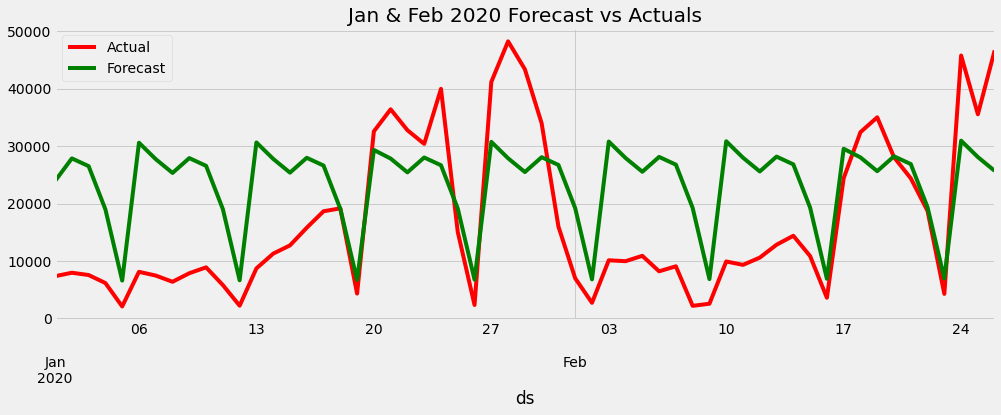

In [30]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Jan & Feb 2020 Forecast vs Actuals')
plt.show()

In [31]:
mape = mean_absolute_percentage_error(X_tst['y'],X_tst_forecast_holiday['yhat'])
print("MAPE",round(mape,4))

MAPE 130.6785


# 调参过程

In [32]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


In [33]:
strt='2019-12-31'
end='2020-02-26'
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='US')
    train_model.fit(X_tr)
    train_forecast = train_model.make_future_dataframe(periods=57, freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    Actual = df[(df['ds']>strt) & (df['ds']<=end)]
    MAPE = mean_absolute_percentage_error(Actual['y'],abs(test['yhat']))
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 104.94306693855413
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 104.94051842425102
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 104.90554026843625
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 105.32192287815019
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Erro

Mean Absolute Percentage Error(MAPE)------------------------------------ 103.64481730563607
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 105.14855364020153
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 103.50317089395806
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 104.54527752762294
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 103.39766470087622
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3

Mean Absolute Percentage Error(MAPE)------------------------------------ 103.83099946534632
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 108.25513752171221
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 103.37465744128886
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 104.21239468782224
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 103.98741126062248
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4

Mean Absolute Percentage Error(MAPE)------------------------------------ 106.54758567357464
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 103.39984113737223
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 106.09836486988154
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 119.97435691351517
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 114.12580494434954
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1

In [34]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,101.858798,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
1,101.877677,"{'changepoint_prior_scale': 0.3, 'holidays_pri..."
2,101.944505,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
3,102.106773,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
4,102.127882,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."


In [35]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 0.2,
 'n_changepoints': 100,
 'seasonality_mode': 'multiplicative'}

In [36]:
# Setup and train model with holidays
final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale= 0.2,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 100,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model.add_country_holidays(country_name='US')
final_model.fit(X_tr)

In [37]:
future = final_model.make_future_dataframe(periods=122, freq='D')
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
814,2020-04-25,12508.079982,-13880.892238,39760.184563
815,2020-04-26,-1367.856438,-30915.433926,24579.684404
816,2020-04-27,27013.591744,-1160.753718,54551.788427
817,2020-04-28,24187.091956,-3015.342831,54156.813714
818,2020-04-29,21838.245799,-5796.636779,50127.658955
819,2020-04-30,24632.042499,-2420.730769,53011.619985
820,2020-05-01,23903.789327,-2950.589578,51645.070576


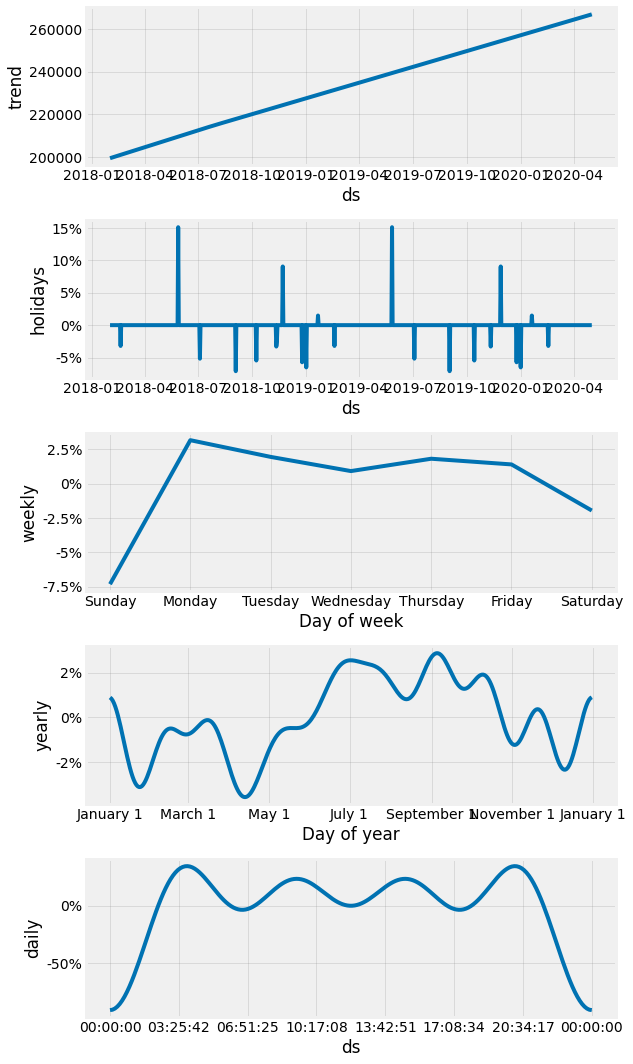

In [38]:
fig = final_model.plot_components(forecast)

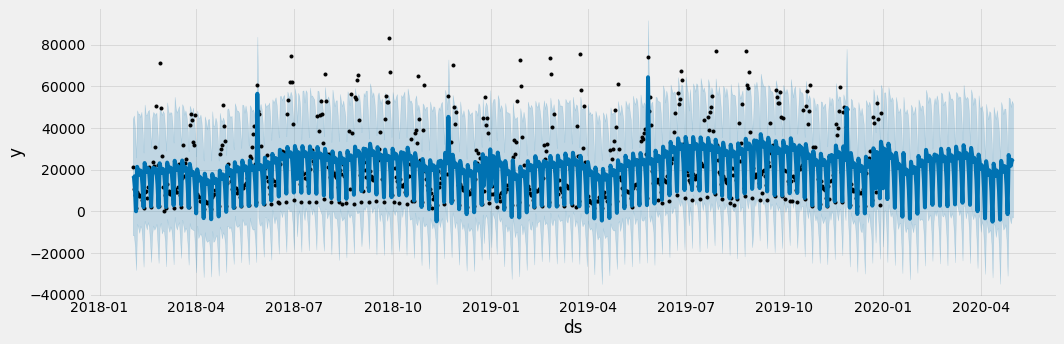

In [39]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_model.plot(forecast,ax=ax)
plt.show()

In [40]:
X_tst_final= final_model.predict(X_tst)
X_tst_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
50,2020-02-20,26806.937957,-1895.876125,55869.191933
51,2020-02-21,25647.095512,-2251.537648,52399.099353
52,2020-02-22,16781.543938,-12134.115731,44048.579480
53,2020-02-23,2670.783649,-23630.659059,30879.007003
54,2020-02-24,30017.077797,2377.119016,58039.616825
55,2020-02-25,26767.907732,381.453433,55563.103114
56,2020-02-26,24012.816063,-2870.229343,51123.465129


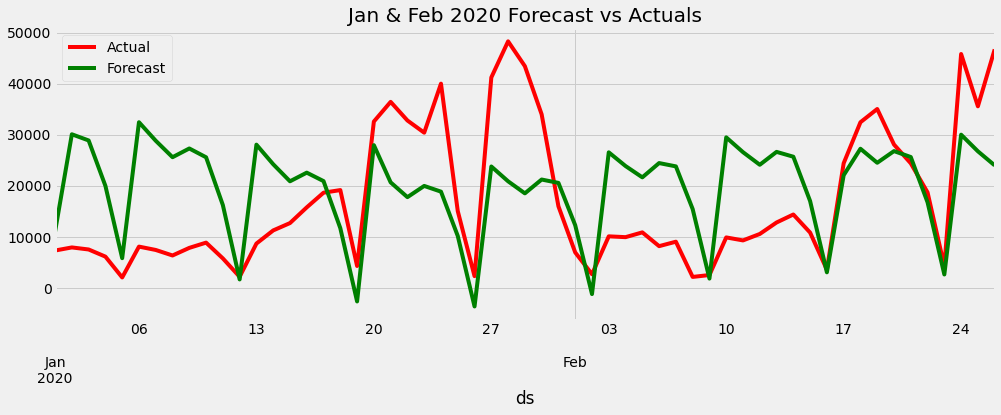

In [41]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Jan & Feb 2020 Forecast vs Actuals')
plt.show()

In [42]:
MAPE = mean_absolute_percentage_error(X_tst['y'],abs(X_tst_final['yhat']))
print('MAPE', MAPE)

MAPE 106.80960312403649


# 加入其他变量或者是特征

In [46]:
end_date = '2019-12-31'
df1 = df.copy()
df1['ds'] = pd.to_datetime(df1['ds'])
df1['days'] = df1['ds'].dt.day
mask1 = (df1['ds'] <= end_date)
mask2 = (df1['ds'] > end_date)
X_tr1 = df1.loc[mask1]
X_tst1 = df1.loc[mask2]
print("train shape",X_tr1.shape)
print("test shape",X_tst1.shape)

train shape (699, 3)
test shape (57, 3)


In [47]:
df1

,ds,y,days
0,2018-02-01,21199.0,1
1,2018-02-02,10634.0,2
2,2018-02-03,7966.0,3
3,2018-02-04,1353.0,4
4,2018-02-05,9497.0,5
...,...,...,...
751,2020-02-22,18723.1,22
752,2020-02-23,4274.9,23
753,2020-02-24,45805.7,24
754,2020-02-25,35566.3,25


In [48]:
final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale= 0.2,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 100,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model.add_country_holidays(country_name='US')
final_model.add_regressor('days')

final_model.fit(X_tr1)

In [49]:
forecast1 = final_model.predict(X_tst1)

In [50]:
forecast1

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Columbus Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2020-01-01,251420.009162,-15718.140975,24410.969711,251420.005495,251420.012328,0.0,0.0,0.0,0.0,...,0.007826,0.007826,0.007826,-0.017379,-0.017379,-0.017379,0.0,0.0,0.0,5175.380301
1,2020-01-02,251454.496339,-15846.185369,25593.603129,251454.478229,251454.512798,0.0,0.0,0.0,0.0,...,0.016727,0.016727,0.016727,-0.017599,-0.017599,-0.017599,0.0,0.0,0.0,4912.431156
2,2020-01-03,251488.983516,-12599.342228,25501.908865,251488.953219,251489.015894,0.0,0.0,0.0,0.0,...,0.013640,0.013640,0.013640,-0.017801,-0.017801,-0.017801,0.0,0.0,0.0,5287.461829
3,2020-01-04,251523.470693,-23339.356219,17859.833125,251523.421477,251523.524614,0.0,0.0,0.0,0.0,...,-0.018505,-0.018505,-0.018505,-0.017980,-0.017980,-0.017980,0.0,0.0,0.0,-1640.413496
4,2020-01-05,251557.957871,-32892.272558,7014.429642,251557.889389,251558.034815,0.0,0.0,0.0,0.0,...,-0.069070,-0.069070,-0.069070,-0.018132,-0.018132,-0.018132,0.0,0.0,0.0,-13197.117315
5,2020-01-06,251592.445048,-7731.196084,32997.679240,251592.358116,251592.547992,0.0,0.0,0.0,0.0,...,0.030487,0.030487,0.030487,-0.018251,-0.018251,-0.018251,0.0,0.0,0.0,13020.881122
6,2020-01-07,251626.932225,-8487.566775,31258.623335,251626.819444,251627.056586,0.0,0.0,0.0,0.0,...,0.018895,0.018895,0.018895,-0.018333,-0.018333,-0.018333,0.0,0.0,0.0,11287.152713
7,2020-01-08,251661.419402,-11005.266499,29982.014271,251661.285013,251661.566807,0.0,0.0,0.0,0.0,...,0.007826,0.007826,0.007826,-0.018376,-0.018376,-0.018376,0.0,0.0,0.0,9694.980314
8,2020-01-09,251695.906579,-6876.711783,33088.178708,251695.742909,251696.076965,0.0,0.0,0.0,0.0,...,0.016727,0.016727,0.016727,-0.018374,-0.018374,-0.018374,0.0,0.0,0.0,13139.355587
9,2020-01-10,251730.393756,-6370.870935,33707.015461,251730.207559,251730.589799,0.0,0.0,0.0,0.0,...,0.013640,0.013640,0.013640,-0.018328,-0.018328,-0.018328,0.0,0.0,0.0,13578.495752


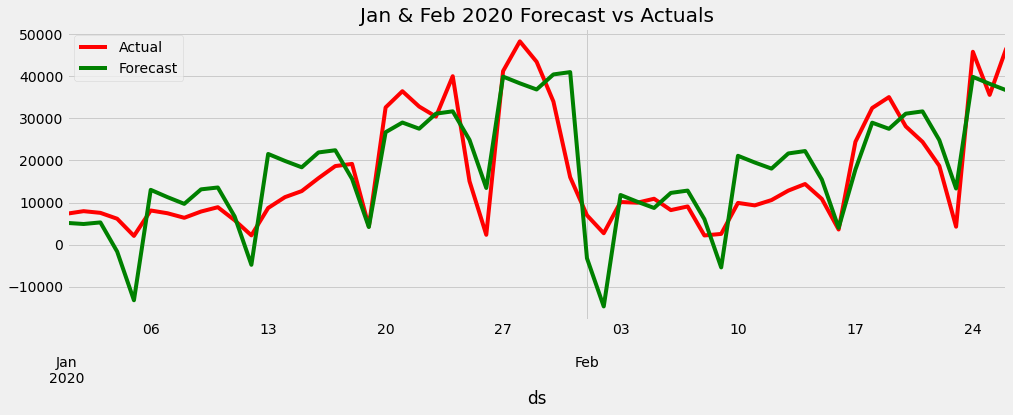

In [51]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
forecast1.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Jan & Feb 2020 Forecast vs Actuals')
plt.show()

In [52]:
MAPE = mean_absolute_percentage_error(X_tst1['y'],abs(forecast1['yhat']))
print('MAPE', MAPE)

MAPE 71.2778258509159


## 训练prophet
## 加进去节假日特征
## 调参
## 加入其他特征